# Kuramoto-Sivashinsky (KS) equation

The physical space KS equation is given by
<hr>
$u_{t} = -u_{xx} - u_{xxxx} - uu_{x}$
<hr>
Instead of solving for $u$ in physical space, you can solve for $\hat{u}$ in spectral space, then convert back to physical space when needed. That is, you can solve
<hr>
$\hat{u}_{t} = {k_x}^{2}(1-{k_x}^{2})\hat{u} - \mathscr{F} \{ \mathscr{F}^{-1} \{ \hat{u} \} \mathscr{F}^{-1} \{ i k_x \hat{u} \}  \} $
<hr>
where $\mathscr{F}$ and $\mathscr{F}^{-1}$ represent the Fourier and inverse Fourier transforms respectively and $\hat{u} = \mathscr{F} \{ u \}$ is a function of the wavenumber $k_{x}$ instead of the physical space grid variable $x$.
With the linear and nonlinear operators
<ul>
    <li> $L = {k_x}^{2}(1-{k_x}^{2})$ </li>
    <li> $\mathscr{N}(u) = - \mathscr{F} \{ \mathscr{F}^{-1} \{ \hat{u} \} \mathscr{F}^{-1} \{ i k_x \hat{u} \}  \} $ </li>
</ul>
the spectral equation is in the form $\hat{u}_{t} = L\hat{u} + \mathscr{N}(\hat{u})$ which can be plugged into one of the rkstiff package solvers


### Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from rkstiff.grids import construct_x_kx_rfft
from rkstiff.derivatives import dx_rfft
from rkstiff.if34 import IF34
%matplotlib inline

### Construct grids

In [12]:
# uniform grid spacing, field assumed to be real-valued -> construct_x_kx_rfft
N = 8192
a,b = 0,32*np.pi
x,kx = construct_x_kx_rfft(N,a,b)

# Linear and nonlinear functions for (spectral) KS equation

In [13]:
L = kx**2*(1-kx**2)
def NL(uf):
    u = np.fft.irfft(uf)
    ux = np.fft.irfft(1j*kx*uf)
    return -np.fft.rfft(u*ux)

# Initial field to be propagated

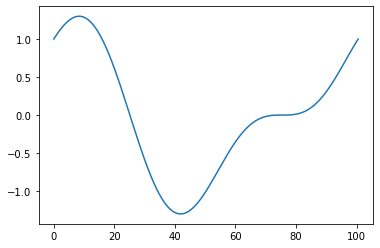

In [14]:
u0 = np.cos(x/16)*(1.+np.sin(x/16))
u0FFT = np.fft.rfft(u0)
plt.plot(x,u0)

# Initialize IF34 solver

In [15]:
if34 = IF34(linop=L,NLfunc=NL,epsilon=1e-4)

# Propagate step by step

tf =  65.1894547223142


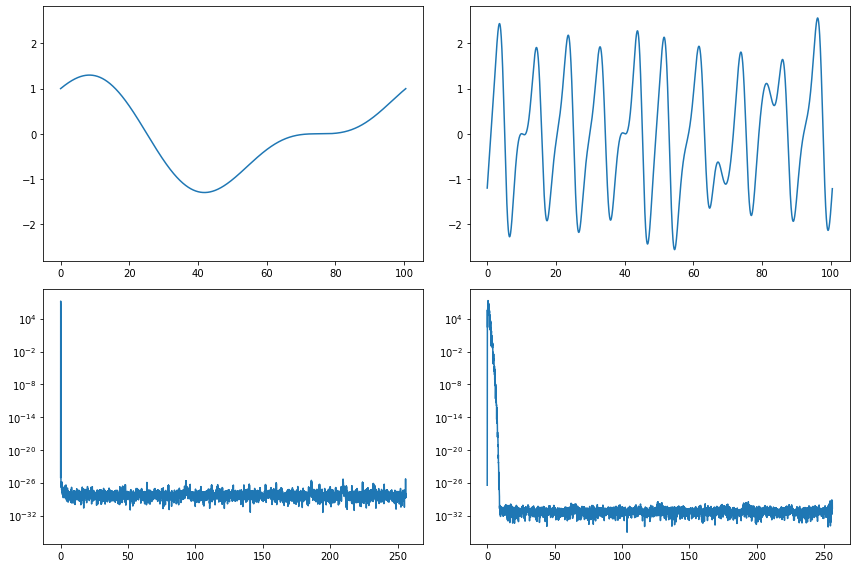

In [16]:
steps = 800
h = 0.01
uFFT = u0FFT.copy()
t = 0
for i in range(steps):
    uFFT,h,h_suggest = if34.step(uFFT,h)
    t += h
    # use suggested step (or not for a constant step size scheme)
    h = h_suggest  
    
print('tf = ',t)
uf = np.fft.irfft(uFFT)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2,sharey = ax1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4,sharey = ax3)
ax1.plot(x,u0)
ax2.plot(x,uf)
ax3.plot(kx,np.abs(u0FFT)**2)
ax4.plot(kx,np.abs(uFFT)**2)
ax3.set_yscale('log')
ax4.set_yscale('log')
fig.tight_layout()

# Propagate from time t0 to tf

In [17]:
# store_data -> propagated field stored in IF34.u at times IF34.t 
# store_freq -> propagated field values stored on every store_freq step (default is every step)
uFFT = if34.evolve(u0FFT,t0=0,tf=50,store_data=True,store_freq=20)

In [18]:
def waterfall(x,t,u,**kwargs):
    if 'figsize' in kwargs:
        fig = plt.figure(figsize=kwargs['figsize'])
    else:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.w_xaxis.set_pane_color((0,0,0,0))
    ax.w_yaxis.set_pane_color((0,0,0,0))
    ax.w_zaxis.set_pane_color((0,0,0,0))
    for i,snapshot in enumerate(u):
        ax.plot(x,t[i]*np.ones_like(x),snapshot,color='black')
    plt.xlim([x[0],x[-1]])
    plt.ylim([t[0],t[-1]])
    plt.tight_layout()
    return ax

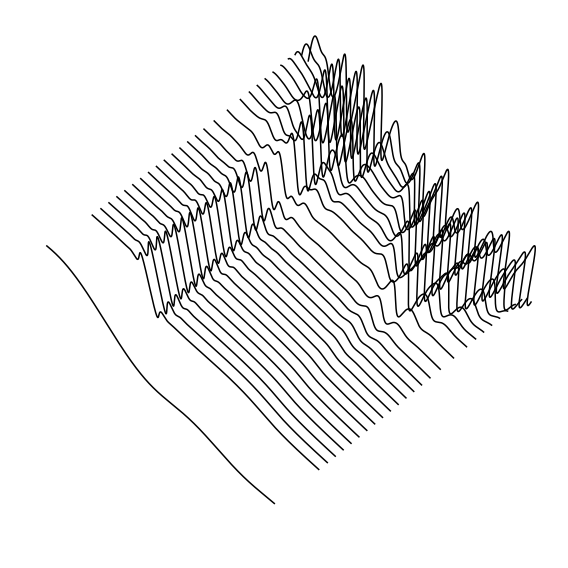

In [19]:
U = []
for u in if34.u:
    U.append(np.fft.irfft(u))
U = np.array(U)
t = np.array(if34.t)
ax = waterfall(x,t,U,figsize=(8,8))
ax.grid(False)
ax.axis(False)
ax.view_init(74,-41)